In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from collect_data import *
from tqdm import tqdm

In [2]:
for img, _ in train_loader:
    print(img.shape) 
    break 

torch.Size([64, 3, 150, 150])


In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes=75):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten_size = self._get_flatten_size()
        
        self.fc1 = nn.Linear(in_features=self.flatten_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        
    def _get_flatten_size(self):
        x = torch.randn(1, 3, 150, 150)
        x = self.max_pool(F.relu(self.conv_layer1(x)))
        x = self.max_pool(F.relu(self.conv_layer2(x)))
        x = self.max_pool(F.relu(self.conv_layer3(x)))
        return x.view(1, -1).size(1)
        
    def forward(self, x):
        x = F.relu(self.conv_layer1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer2(x))
        x = self.max_pool(x)
        x = F.relu(self.conv_layer3(x))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model = CNN(num_classes=75).to(device)
print(model)

CNN(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20736, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=75, bias=True)
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
def train(model, num_epochs, loss_fn=loss_fn, train_loader=train_loader, optimizer=optimizer, device=device):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        correct_train = 0
        total_train = 0
        
        for batch in tqdm(train_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_train += labels.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()
            
        acc_train = 100 * correct_train / total_train
        train_acc.append(acc_train)
        avg_train_loss = total_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        
        model.eval()
        loss_val = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader):
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, labels)

                loss_val += loss.item()
                total_val += labels.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
                
        acc_val = 100 * correct_val / total_val
        val_acc.append(acc_val)
        avg_val_loss = total_loss / len(val_loader)
        val_loss.append(avg_val_loss)
        
        print(f"Epoch ({epoch+1}/{num_epochs}) train accuracy: {acc_train}, val accuracy: {acc_val}, train loss: {avg_train_loss}, val loss: {avg_val_loss}")
        
    return train_loss, val_loss, train_acc, val_acc

In [8]:
def plot_training_curve(train_acc, val_acc, train_loss, val_loss):
    threshold = 95
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (95%)')
    
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.title("Training & Validation Metrics")
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 21/21 [00:14<00:00,  1.44it/s]


Epoch (1/30) train accuracy: 6.597422581265628, val accuracy: 13.23076923076923, train loss: 3.930920545647784, val loss: 15.349308797291346


100%|██████████| 21/21 [00:14<00:00,  1.48it/s]


Epoch (2/30) train accuracy: 22.061934987497597, val accuracy: 26.692307692307693, train loss: 2.9614560080737604, val loss: 11.563780602954683


100%|██████████| 21/21 [00:14<00:00,  1.48it/s]


Epoch (3/30) train accuracy: 35.29524908636276, val accuracy: 35.61538461538461, train loss: 2.4088732789202436, val loss: 9.406076612926665


100%|██████████| 21/21 [00:14<00:00,  1.47it/s]


Epoch (4/30) train accuracy: 43.27755337564916, val accuracy: 40.07692307692308, train loss: 2.0756550445789244, val loss: 8.104938745498657


100%|██████████| 21/21 [00:14<00:00,  1.46it/s]


Epoch (5/30) train accuracy: 48.874783612233124, val accuracy: 44.84615384615385, train loss: 1.8535829084675486, val loss: 7.237799928301857


100%|██████████| 21/21 [00:14<00:00,  1.43it/s]


Epoch (6/30) train accuracy: 52.77938065012503, val accuracy: 47.23076923076923, train loss: 1.6701579588215525, val loss: 6.521569172541301


100%|██████████| 21/21 [00:14<00:00,  1.42it/s]


Epoch (7/30) train accuracy: 55.70301981150221, val accuracy: 47.76923076923077, train loss: 1.5480606817617648, val loss: 6.044808376403082


100%|██████████| 21/21 [00:14<00:00,  1.47it/s]


Epoch (8/30) train accuracy: 59.011348336218504, val accuracy: 51.84615384615385, train loss: 1.4126287815047474, val loss: 5.515979051589966


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Epoch (9/30) train accuracy: 60.74245047124447, val accuracy: 51.84615384615385, train loss: 1.337847757630232, val loss: 5.223976958365667


100%|██████████| 21/21 [00:14<00:00,  1.44it/s]


Epoch (10/30) train accuracy: 62.22350452010002, val accuracy: 51.53846153846154, train loss: 1.268600393359254, val loss: 4.953582488355183


100%|██████████| 21/21 [00:14<00:00,  1.46it/s]


Epoch (11/30) train accuracy: 64.9740334679746, val accuracy: 56.53846153846154, train loss: 1.193278697205753, val loss: 4.65946919861294


100%|██████████| 21/21 [00:14<00:00,  1.47it/s]


Epoch (12/30) train accuracy: 66.97441815733795, val accuracy: 52.07692307692308, train loss: 1.1115767774058551, val loss: 4.340442654632387


100%|██████████| 21/21 [00:14<00:00,  1.47it/s]


Epoch (13/30) train accuracy: 68.18618965185613, val accuracy: 55.53846153846154, train loss: 1.078426190265795, val loss: 4.21099750484739


100%|██████████| 21/21 [00:14<00:00,  1.46it/s]


Epoch (14/30) train accuracy: 69.16714752837085, val accuracy: 57.0, train loss: 1.0251441299915314, val loss: 4.002943745681217


100%|██████████| 21/21 [00:14<00:00,  1.42it/s]


Epoch (15/30) train accuracy: 71.85997307174456, val accuracy: 58.23076923076923, train loss: 0.9300406000963072, val loss: 3.631587105137961


100%|██████████| 21/21 [00:14<00:00,  1.45it/s]


Epoch (16/30) train accuracy: 72.76399307559146, val accuracy: 58.53846153846154, train loss: 0.8807163776420965, val loss: 3.438987760316758


100%|██████████| 21/21 [00:14<00:00,  1.47it/s]


Epoch (17/30) train accuracy: 73.72571648393922, val accuracy: 60.0, train loss: 0.864645333551779, val loss: 3.376234159583137


100%|██████████| 21/21 [00:14<00:00,  1.45it/s]


Epoch (18/30) train accuracy: 75.45681861896519, val accuracy: 59.0, train loss: 0.7871984177973212, val loss: 3.073822393303826


100%|██████████| 21/21 [00:14<00:00,  1.46it/s]


Epoch (19/30) train accuracy: 76.70705904981727, val accuracy: 61.23076923076923, train loss: 0.7782333642244339, val loss: 3.0388159936382655


100%|██████████| 21/21 [00:15<00:00,  1.33it/s]


Epoch (20/30) train accuracy: 76.57241777264859, val accuracy: 59.53846153846154, train loss: 0.7527286813753408, val loss: 2.939226279656092


100%|██████████| 21/21 [00:15<00:00,  1.40it/s]


Epoch (21/30) train accuracy: 79.14983650702058, val accuracy: 60.61538461538461, train loss: 0.6874251431081353, val loss: 2.6842315111841475


100%|██████████| 21/21 [00:15<00:00,  1.38it/s]


Epoch (22/30) train accuracy: 79.20753991152145, val accuracy: 61.15384615384615, train loss: 0.6654807263758125, val loss: 2.598543788705553


100%|██████████| 21/21 [00:16<00:00,  1.31it/s]


Epoch (23/30) train accuracy: 80.82323523754569, val accuracy: 61.0, train loss: 0.6169776527619943, val loss: 2.409150834594454


100%|██████████| 21/21 [00:15<00:00,  1.37it/s]


Epoch (24/30) train accuracy: 80.70782842854395, val accuracy: 60.07692307692308, train loss: 0.6150612671200822, val loss: 2.401667804945083


100%|██████████| 21/21 [00:15<00:00,  1.38it/s]


Epoch (25/30) train accuracy: 82.43893056356991, val accuracy: 61.0, train loss: 0.5493759124017343, val loss: 2.1451821341401054


100%|██████████| 21/21 [00:15<00:00,  1.37it/s]


Epoch (26/30) train accuracy: 82.70821311790729, val accuracy: 60.0, train loss: 0.5525837024537529, val loss: 2.1577077905337014


100%|██████████| 21/21 [00:15<00:00,  1.34it/s]


Epoch (27/30) train accuracy: 82.9582612040777, val accuracy: 60.84615384615385, train loss: 0.5375487946155595, val loss: 2.0990000551655177


100%|██████████| 21/21 [00:14<00:00,  1.43it/s]


Epoch (28/30) train accuracy: 84.90094248894017, val accuracy: 61.92307692307692, train loss: 0.4880849306539791, val loss: 1.9058554435060138


100%|██████████| 21/21 [00:15<00:00,  1.38it/s]


Epoch (29/30) train accuracy: 84.4200807847663, val accuracy: 61.61538461538461, train loss: 0.4854597690992239, val loss: 1.89560481267316


100%|██████████| 21/21 [00:15<00:00,  1.39it/s]


Epoch (30/30) train accuracy: 86.45893441046356, val accuracy: 61.92307692307692, train loss: 0.44214113928922794, val loss: 1.7264558772246044


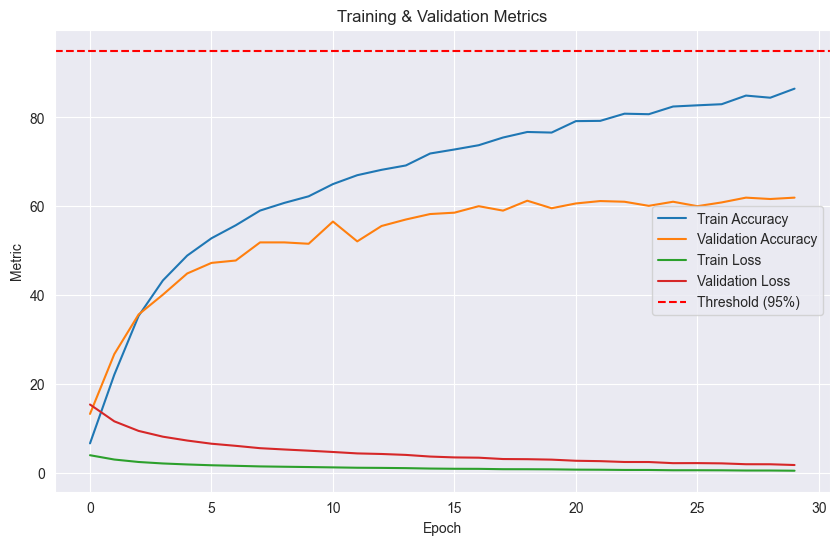

In [9]:
train_loss, val_loss, train_acc, val_acc = train(model, num_epochs=30)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)